In [29]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [30]:
def sliding_window(raw_data, window_size, stride=1):
    res = []
    left = right = 0
    while left + window_size <= len(raw_data):
        res.append(raw_data[left: left + window_size])
        left += stride
        right += stride
    return np.array(res, dtype=np.float32)

def data_extend(voltage, current, temperature, window_size=225, stride=45):
    assert len(voltage) == len(current) and len(current) == len(temperature), "Error!"
    voltage_extend = sliding_window(voltage, window_size=window_size, stride=stride)
    current_extend = sliding_window(current, window_size=window_size, stride=stride)
    temperature_extend = sliding_window(temperature, window_size=window_size, stride=stride)

    return np.array((voltage_extend, current_extend, temperature_extend))

def build_samples(voltage, current, temperature, target):
    samples = []
    data_extended = data_extend(voltage, current, temperature)
    for j in range(data_extended.shape[1]):
        seq = np.vstack((data_extended[0][j], data_extended[1][j], data_extended[2][j]))
        samples.append((seq, target))
    return np.array(samples, dtype=object)

# # sliding_window 函数测试
# raw_data = np.array(range(10))
# data = sliding_window(raw_data=raw_data, window_size=3, stride=1)
# # data_extend 函数测试
# vol, cur, tem = raw_data, raw_data * 10, raw_data * 100
# data_extended = data_extend(vol, cur, tem, window_size=2, stride=1)
# print(data_extended.shape) # (num_features, num_windwos aka num_samples, window_size)
# # build_samples 函数测试

In [31]:
dataset_path = "../data/batch3.pkl"
with open(dataset_path, "rb") as f:
    dataset = pickle.load(f)

In [32]:
batteries = dict()
keys = list(dataset.keys())[0:16] # 取前16块电芯数据
rated_capacity = 1.1

v_scaler = MinMaxScaler(feature_range=(-1, 1))
i_scaler = MinMaxScaler(feature_range=(-1, 1))
t_scaler = MinMaxScaler(feature_range=(-1, 1))
qc_scaler = MinMaxScaler(feature_range=(0, 1))
qd_scaler = MinMaxScaler(feature_range=(0, 1))

for idx, key in enumerate(keys):
    # 每次取一块电池的数据 dataset[key]
    
    # 构造循环数据
    # print(idx, dataset[key]["cycles"].keys())
    cycle_data = dict()
    for i in dataset[key]["cycles"].keys():
        cycle_data[int(i)] = {
            "V": v_scaler.fit_transform(dataset[key]["cycles"][i]["V"].astype(np.float32).reshape(-1, 1)).flatten(),
            "I": i_scaler.fit_transform(dataset[key]["cycles"][i]["I"].astype(np.float32).reshape(-1, 1)).flatten(),
            # "T": t_scaler.fit_transform(dataset[key]["cycles"][i]["T"].astype(np.float32).reshape(-1, 1)).flatten(),
            "Q": qc_scaler.fit_transform(dataset[key]["cycles"][i]["Qc"].astype(np.float32).reshape(-1, 1)).flatten() - qd_scaler.fit_transform(dataset[key]["cycles"][i]["Qd"].astype(np.float32).reshape(-1, 1)).flatten(),
        }

    # 构造数据集
    batteries[idx] = {
        "cycle_len": int(dataset[key]["cycle_life"].item()) - 1,    # 循环圈数
        "charge_policy": dataset[key]["charge_policy"],             # 充放电配置
        "cycle_data": cycle_data,                                   # 循环数据
        "discharge_capacity": dataset[key]["summary"]["QD"]         # 放电容量
    }

# print("----- 电池数据 -----")
# for cnt in range(len(batterys)):
#     print(f"电池 {keys[cnt]} 的循环圈数： ", len(batterys[cnt]["cycle_data"].keys()))

# print("----- Battery 1 电池循环数据 -----")
# test_battery = batteries[0]
# print("循环圈数： ", test_battery["cycle_len"], "， 充电策略： ", test_battery["charge_policy"])
# print("放电容量： ", test_battery["discharge_capacity"])
# print("循环数据： ")
# # print(test_battery["cycle_data"])
# for key in test_battery["cycle_data"].keys():
#     print("  ", key, "：")
#     print("\t", test_battery["cycle_data"][key]) # 打印第一块电池每个循环的VIT信息

In [33]:
# 保存多元时间序列数据和标签到npy文件，格式为（sequence，target）
names = ["b3c" + str(num).rjust(2, "0") for num in range(16)]

storage_path = "../data/124_commercial_batteries/ts2img_dataset"
for idx, key in enumerate(keys):
    dataset = []
    cell = batteries[idx]
    cycle_len = cell["cycle_len"]
    # print(type(cycle_len), cycle_len)
    for i in range(cycle_len):
        # plt.plot(cell["cycle_data"][i]["V"]) # 绘制电压曲线
        # plt.plot(cell["cycle_data"][i]["I"]) # 绘制电流曲线
        # plt.plot(cell["cycle_data"][i]["Q"]) # 绘制充放电电量曲线
        # plt.legend(["V", "I", "Q"])
        # plt.plot(cell["cycle_data"][i]["T"]) # 绘制温度曲线
        # plt.plot((cell["cycle_data"][i]["QC"] - cell["cycle_data"][i]["QD"]) / rated_capacity) # 绘制SOC曲线（使用额定容量）
        # print(np.argmax(cell["cycle_data"][i]["Q"])) # 返回SOC序列中的最大值索引，为充放电切换时刻
        samples = build_samples(cell["cycle_data"][i]["V"], cell["cycle_data"][i]["I"], cell["cycle_data"][i]["Q"], cell["discharge_capacity"][i])
        dataset.append(samples)
    #     break
    # break
    # 拉平数据集（消除充放电循环维度）
    dataset_to_save = []
    for cycle_data in dataset:
        for sample in cycle_data:
            dataset_to_save.append(np.array(sample))

    np.save(os.path.join(storage_path, names[idx] + ".npy"), np.array(dataset_to_save))
    print(f"cell {key} data save to path: {os.path.join(storage_path, names[idx] + '.npy')}")

cell b3c0 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c00.npy
cell b3c1 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c01.npy
cell b3c2 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c02.npy
cell b3c3 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c03.npy
cell b3c4 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c04.npy
cell b3c5 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c05.npy
cell b3c6 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c06.npy
cell b3c7 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c07.npy
cell b3c8 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c08.npy
cell b3c9 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c09.npy
cell b3c10 data save to path: ../data/124_commercial_batteries/ts2img_dataset/b3c10.npy
cell b3c11 data save to path: ../data/124_

(11761, 2)
[[-8.83993864e-01 -8.47249269e-01 -7.96526909e-01 -7.44080067e-01
  -6.76413774e-01 -6.14428759e-01 -5.40226698e-01 -4.86635685e-01
  -4.12559748e-01 -3.52776289e-01 -2.90276527e-01 -2.44781494e-01
  -2.00099230e-01 -1.67804718e-01 -1.30851507e-01 -1.16430521e-01
  -1.01118088e-01 -8.37795734e-02 -6.95707798e-02 -5.62856197e-02
  -4.22139168e-02 -2.95963287e-02 -1.43303871e-02 -1.19209290e-05
   1.40037537e-02  2.77655125e-02  4.23903465e-02  5.66480160e-02
   6.99126720e-02  8.28440189e-02  9.63971615e-02  1.09614372e-01
   1.23386860e-01  1.36999846e-01  1.50778294e-01  1.63722754e-01
   1.77484512e-01  1.90944910e-01  2.04889059e-01  2.18405247e-01
   2.32045650e-01  2.44563103e-01  2.57657528e-01  2.71181107e-01
   2.84777403e-01  2.98194647e-01  3.11432123e-01  3.24787617e-01
   3.38119268e-01  3.51137400e-01  3.64661932e-01  3.77474070e-01
   3.90554190e-01  4.03766632e-01  4.16603565e-01  4.29100990e-01
   4.42077398e-01  4.54766512e-01  4.67725039e-01  4.80705023e-01

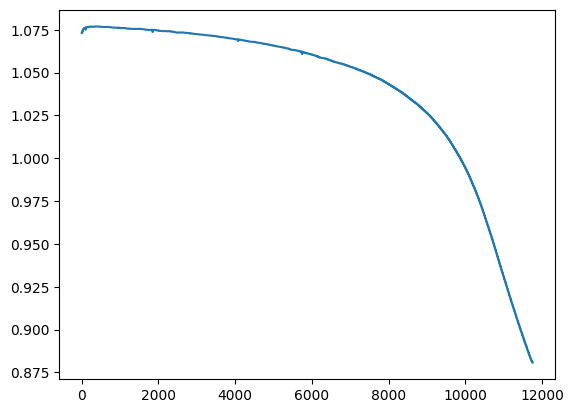

In [34]:
# import random
# random.seed(0)
# num = random.randint(0, 15)
# print(num) # 12

# 读取数据测试
path = "../data/124_commercial_batteries/ts2img_dataset/b3c12.npy"
load_data = np.load(path, allow_pickle=True) # 11761
print(load_data.shape) # (11761, 2)

# 训练/验证过程中如何读取数据集？
# print(load_data[0])
cap = []
for sample in load_data:
    target = sample[1]
    cap.append(target)

for X, y in load_data:
    print(X)
    print(y)
    break

plt.plot(cap)